## Predicting Heart Disease Through Classification with Health Indicators

Yiyao Ru, 
Liam Sissons,
Nizel Abalos,
Sebastian Yeo

## Introduction

  “Heart disease” refers to a varying number of heart related conditions that may include arrhythmias, heart attack, or even heart failure. There are several risk factors that may contribute to the development of heart disease including unhealthy lifestyle, genetics, smoking, and more. In particular, high blood pressure and high cholesterol are main factors that may contribute to the development of heart disease (About heart disease 2022).  	
  
  This data analysis will be exploring the relationship between heart disease and several variables including cholesterol, age, fasting blood sugar and resting blood pressure. The specific data set from Cleveland was chosen due to the prevalence of heart disease related to lifestyle and health factors in the United States (U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? 2020). The dataset includes health related test results collected from about 300 patients in Cleveland and originates from the Cleveland Clinic Foundation. 
  
      
The aim is to address the question: Is it possible to predict the risk level of heart disease (ranging from 0-4, 0 indicating no presence, to 4 being very risky) in Cleveland patients using our selected variables (cholesterol level, age, fasting blood sugar and resting blood pressure)?


## Preliminary explanatory data analysis

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
processed_cleveland_hd <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

In [6]:
colnames(processed_cleveland_hd) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
head(processed_cleveland_hd)
tail(processed_cleveland_hd)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
297,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [8]:
#This will be the data that we will use with age (age), cholesterol (chol), 
#fasting blood sugar (fbs), and resting blood pressure (trestbps) being our 
#predictor variables to identify the severity of heart disease an individual has
#and the diagnosis of heart disease (num) being our categorical variable.

processed_cleveland_hd <- processed_cleveland_hd |>
    select(age, chol, fbs, trestbps, num) |>
    mutate(num = as.factor(num))
na.omit(head(processed_cleveland_hd))
na.omit(tail(processed_cleveland_hd))

,age,chol,fbs,trestbps,num
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,67,286,0,160,2
2,67,229,0,120,1
3,37,250,0,130,0
4,41,204,0,130,0
5,56,236,0,120,0
6,62,268,0,140,3


,age,chol,fbs,trestbps,num
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
297,57,241,0,140,1
298,45,264,0,110,1
299,68,193,1,144,2
300,57,131,0,130,3
301,57,236,0,130,1
302,38,175,0,138,0


In [9]:
#Splitting the data into a training and testing data set
set.seed(1234)

cleveland_hd_split <- initial_split(processed_cleveland_hd, prop = 0.75, strata = num)
cleveland_hd_train <- training(cleveland_hd_split)
cleveland_hd_test <- testing(cleveland_hd_split)

In [10]:
cleveland_predictor_means <- cleveland_hd_train |>
    group_by(num) |>
    mutate(avg_chol = mean(chol)) |>
    mutate(avg_trestbps = mean(trestbps)) |>
    select(num, avg_chol, avg_trestbps)

In [7]:
cleveland_observations_train <- cleveland_hd_train |>
    select(num, age, fbs, chol, trestbps) |>
    group_by(num) |>
    mutate(avg_chol = mean(chol)) |>
    mutate(avg_trestbps = mean(trestbps)) |>
    select(num, avg_chol, avg_trestbps) |>
    arrange(num)

cleveland_observations <- cleveland_hd_train |>
    group_by(num) |>
    summarise(count = n())

cleveland <- merge(cleveland_observations_train, cleveland_observations, on = "num") |>
    select(num, count, avg_chol, avg_trestbps)

distinct(cleveland)

num,count,avg_chol,avg_trestbps
<fct>,<int>,<dbl>,<dbl>
0,121,244.2975,128.7190
1,40,250.7750,136.3500
2,26,250.4231,135.4231
3,25,245.1200,138.8800
4,13,253.3846,138.7692


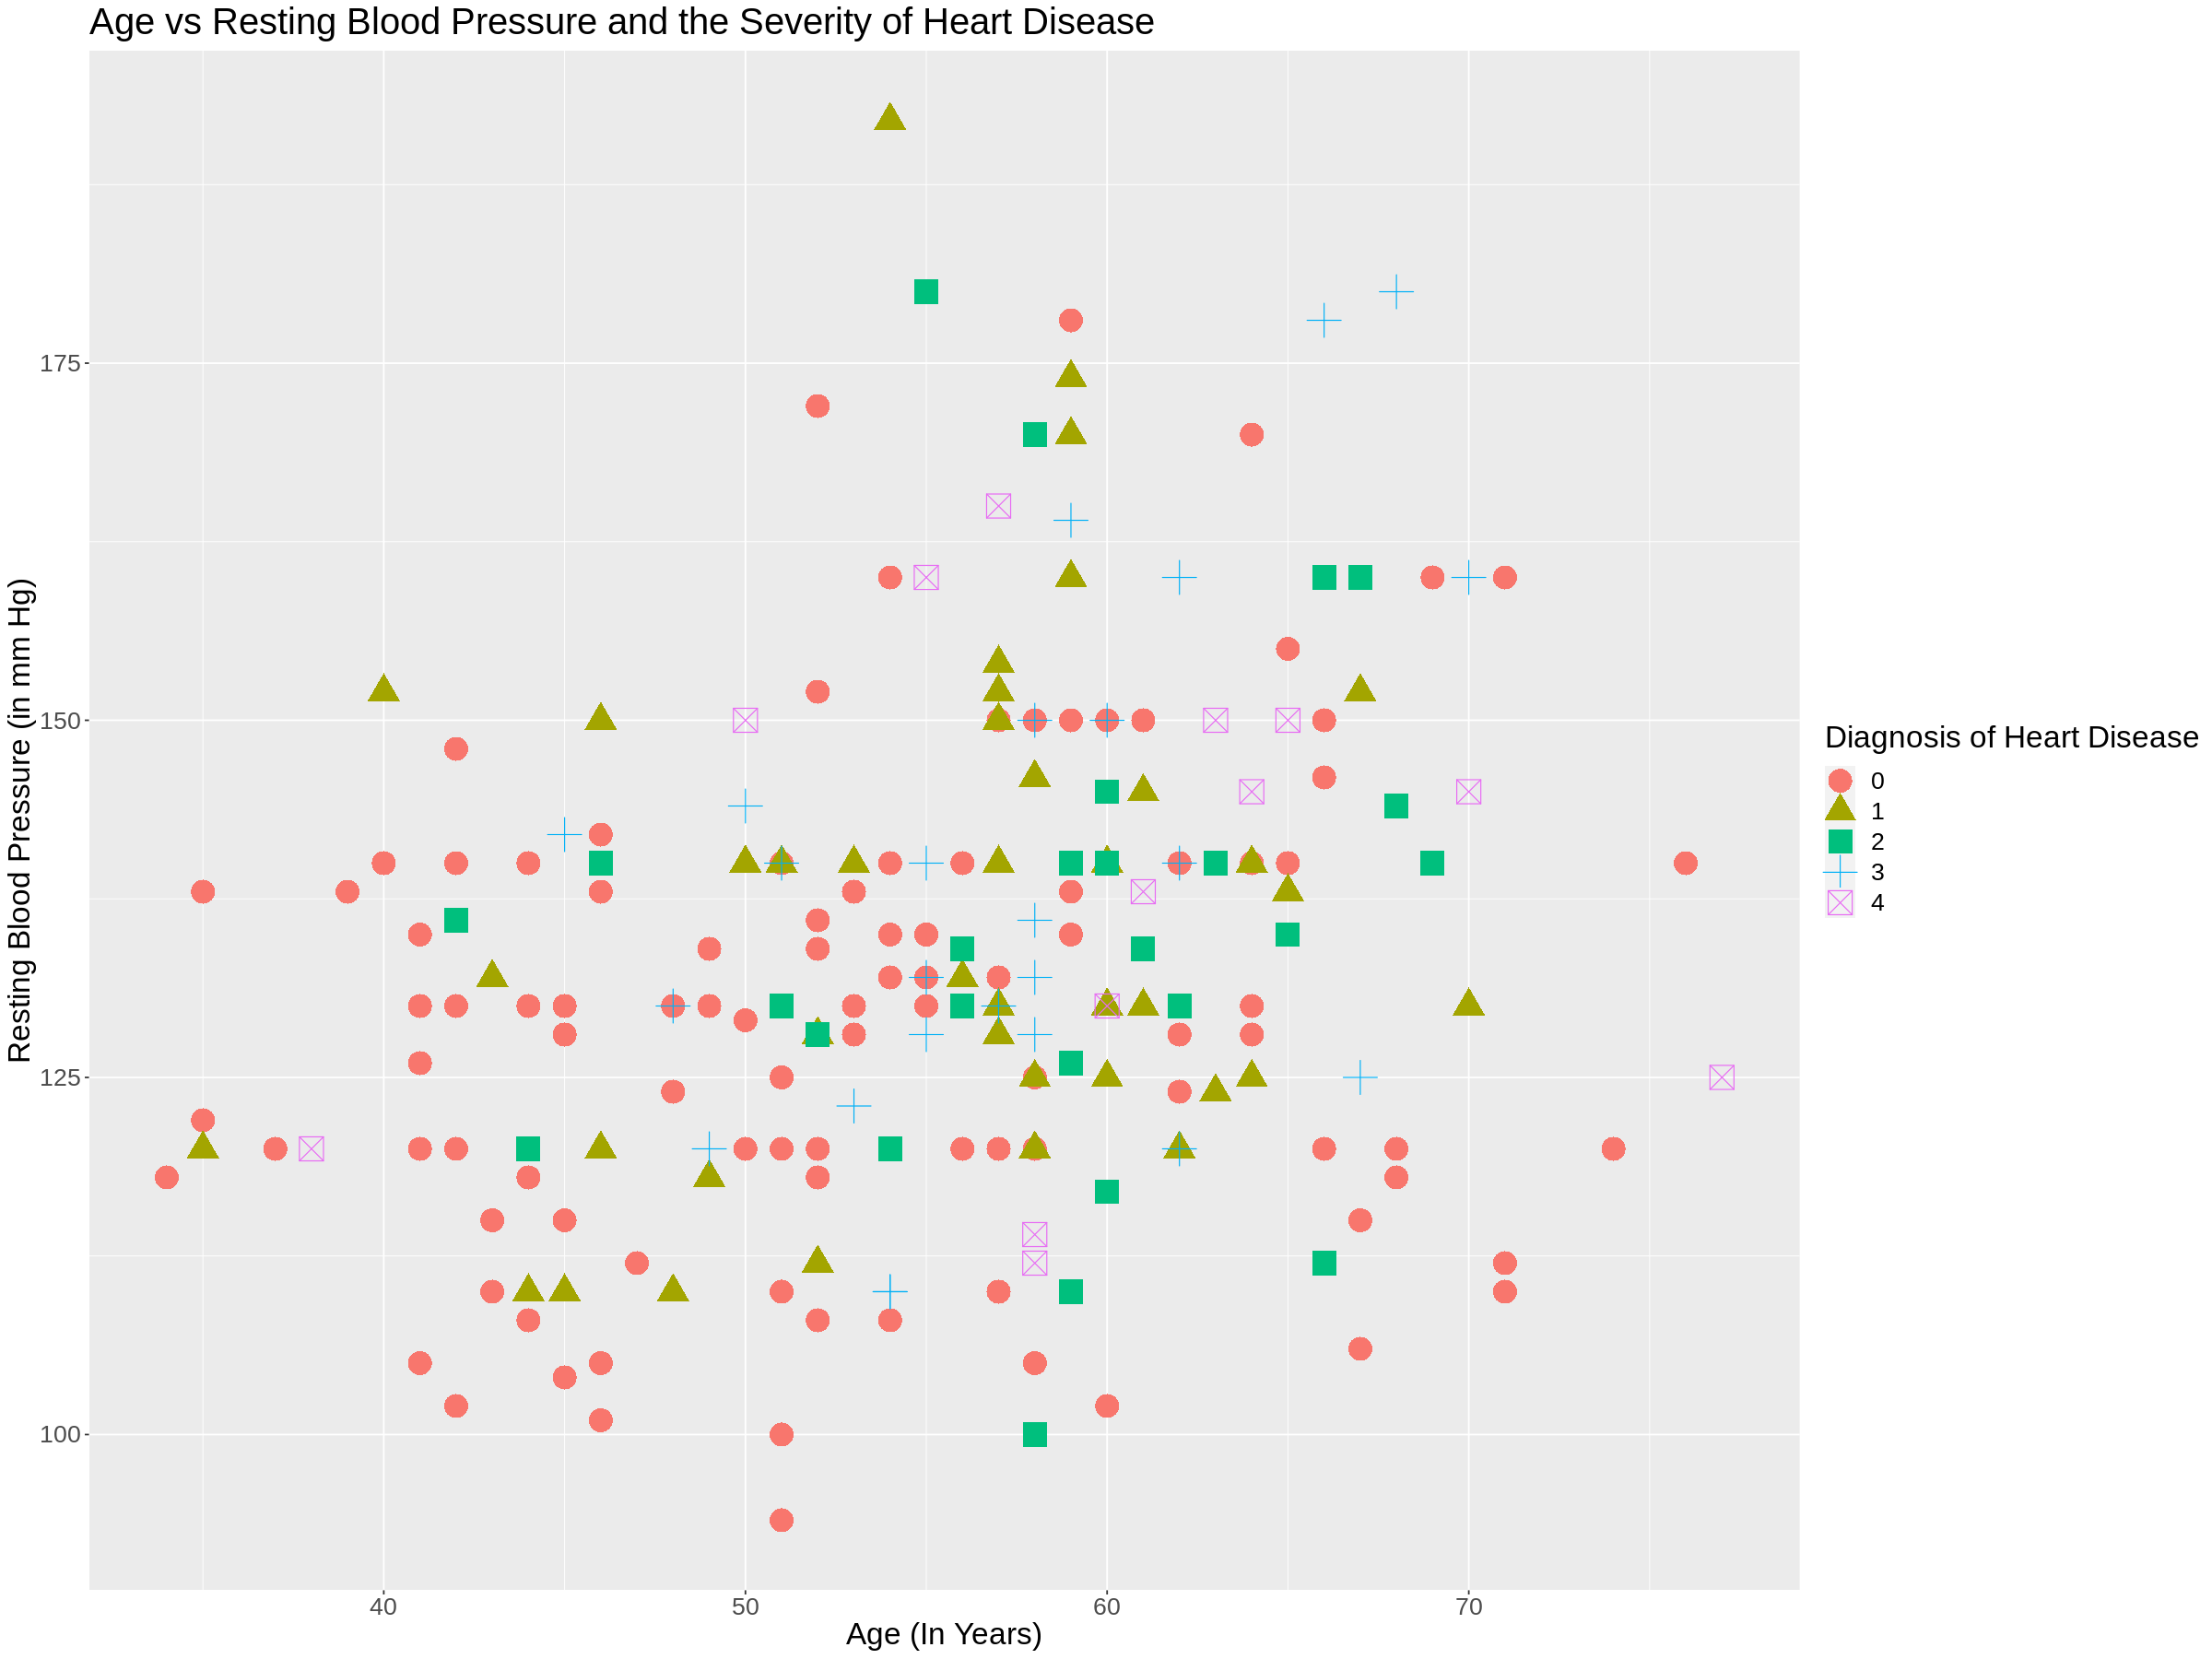

In [8]:
options(repr.plot.width = 20, repr.plot.height = 15)

cleveland_trestbp_plot <- cleveland_hd_train |>
    ggplot(aes(x = age, 
               y = trestbps, 
               colour = num,
               shape = num)) +
        labs(x = "Age (In Years)",
             y = "Resting Blood Pressure (in mm Hg)",
             colour = "Diagnosis of Heart Disease",
             shape = "Diagnosis of Heart Disease") +
        ggtitle("Age vs Resting Blood Pressure and the Severity of Heart Disease") +
        geom_point(size = 7) +
        theme(text = element_text(size = 20))
cleveland_trestbp_plot

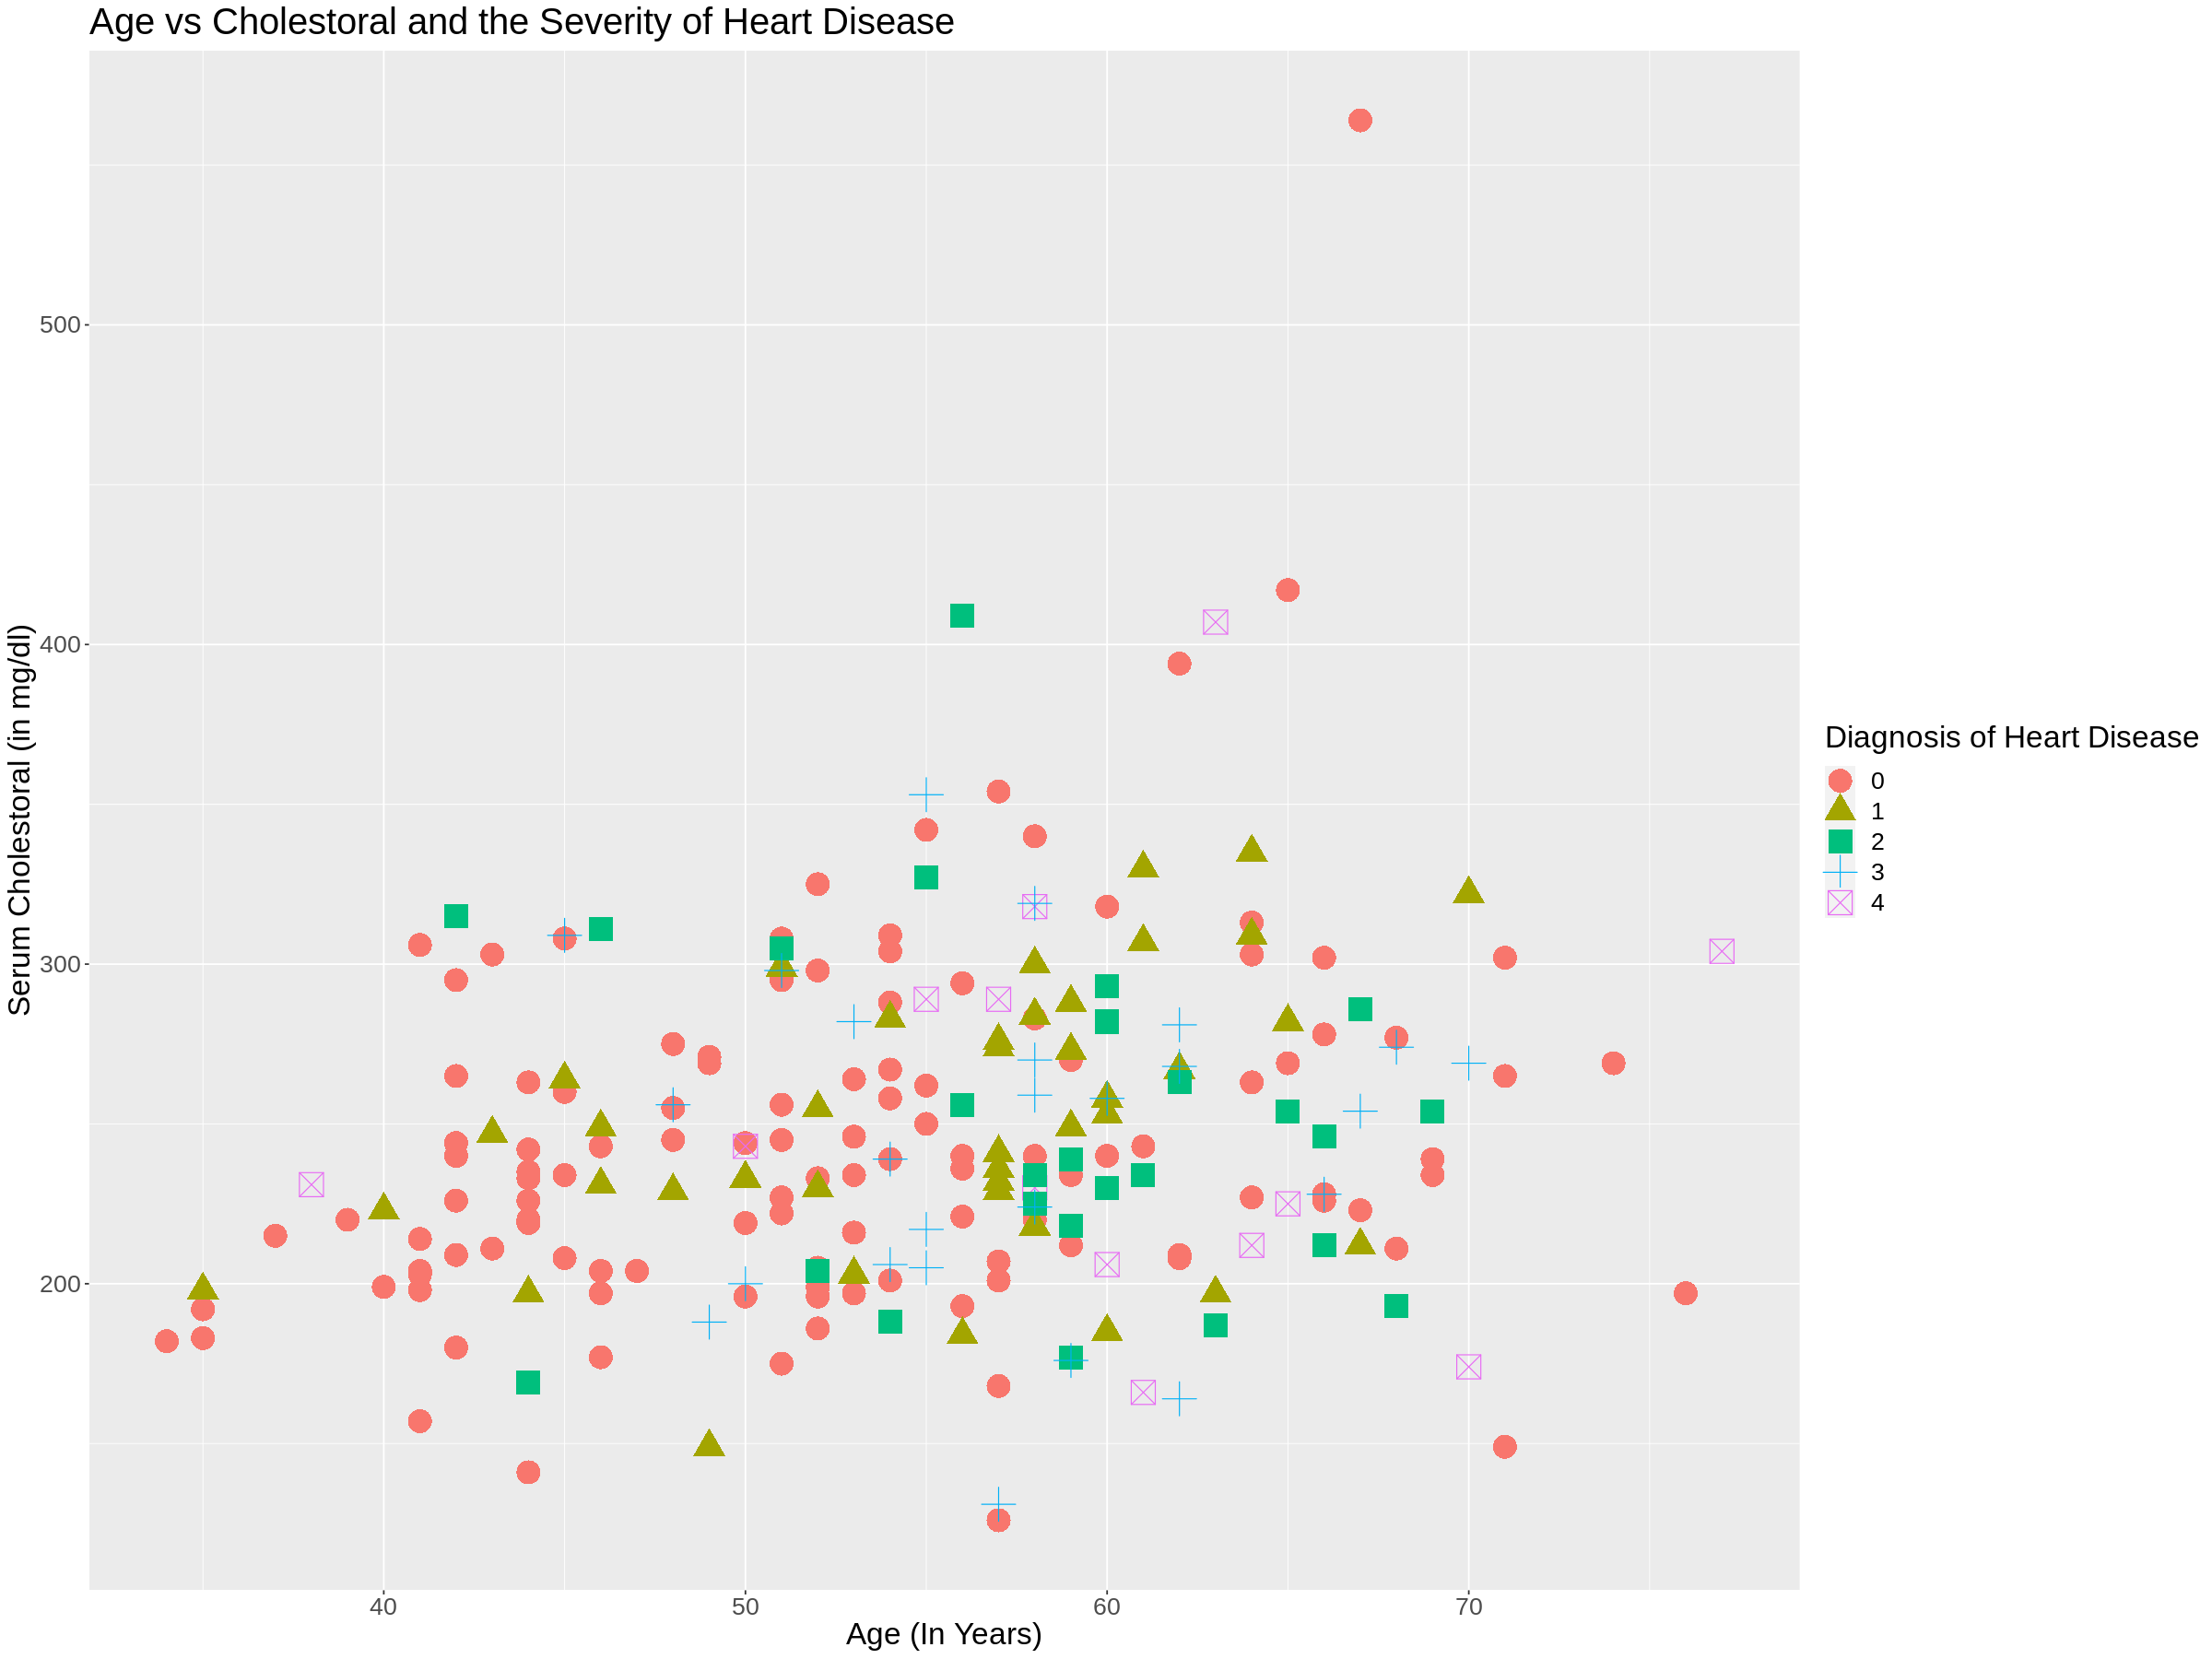

In [9]:
options(repr.plot.width = 20, repr.plot.height = 15)

cleveland_chol_plot <- cleveland_hd_train |>
    ggplot(aes(x = age, 
               y = chol, 
               colour = num,
               shape = num)) +
        labs(x = "Age (In Years)",
             y = "Serum Cholestoral (in mg/dl)",
             colour = "Diagnosis of Heart Disease",
             shape = "Diagnosis of Heart Disease") +
        ggtitle("Age vs Cholestoral and the Severity of Heart Disease") +
        geom_point(size = 7) +
        theme(text = element_text(size = 20))
cleveland_chol_plot

## Methods

 The variables that will be examined are cholesterol (chol), age (age), fasting blood sugar (fbs) and resting blood pressure (trestbps). That being said, other unneeded columns will be filtered out. The required libraries to be loaded include tidyverse, repr, tidymodels and RColorBrewer. The selected variables will be used to create a knn classification model to predict heart disease risk. When building the model, the data will be split into two groups: training and testing. The training data will be used to train the model, and then be tested with the testing data. Since the value of k in the model might influence the accuracy of the model, various values of k will be tested to determine the k with the highest accuracy. The results will be visualized as a line graph with the accuracies of the models and the values of k, as that will help answer the question.

## Expected Outcomes and Questions

 The expected outcome of this data analysis is to determine the risk level for heart disease (ranging from 0-4, 0 indicating no presence, to 4 being very risky) based on the chosen variables  (cholesterol level, age, fasting blood sugar and resting blood pressure). Based on previous knowledge, high cholesterol, blood sugar and blood pressure will likely be associated with higher prevalence of heart disease. By identifying how these variables influence risk of heart disease for a certain age group, medical professionals could identify patients with high risk earlier and provide appropriate care and prevention. 
 This data analysis could lead to future questions regarding other potential risk factors and how much they influence the likelihood of developing heart disease. Another question that this data set does not address is whether or not certain variables are influenced by genetic factors or lifestyle and how this difference could change the way they are addressed by medical professionals.


## Work Cited

About heart disease. Centers for Disease Control and Prevention. 
(2022, July 12). Retrieved …March 2, 2023, from 
https://www.cdc.gov/heartdisease/about.htm 

U.S. health care from a global perspective, 2019: Higher spending, worse outcomes? U.S. Health …Care from a Global Perspective, 2019 | Commonwealth Fund. (2020, January 30). Retrieved …March 2, 2023, from …https://www.commonwealthfund.org/publications/issue-briefs/2020/jan/us-health-care-global-p…erspective-2019#:~:text=More%20than%20one%2Dquarter%20of,less%20in%20all%20other…%20countries 